# Tune decision thresholds

Decision threshold tuning needs to be done in the inner loop, e.g. the validation set.
https://stackoverflow.com/questions/52093388/how-to-choose-optimal-threshold-for-class-probabilities

MCC depends on the thresholds, is not a threshold free method such as AUPRC. As initial experiment, take optimized model and a posteriori optimize the thresholds.   

Thresholding is a bit ill-defined when dealing with multi-class problems, reweighing the probabilities seems more sensible.

In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
sys.path.append('..')
from plotting_utils import make_conf_matrix
from sklearn.metrics import matthews_corrcoef
from investigate_model.plotting_utils import fix_eukarya_preds
df = pd.read_csv('../investigate_model/all_model_outputs.csv')
df = fix_eukarya_preds(df)

### Get Validation split confusion matrixmatthews_corrcoef

In [8]:
def average_partition_validation_probs_and_predict(df):
    labelidx = {'p_NO': 0, 'p_SPI': 1, 'p_SPII': 2, 'p_TAT':3}

    df = df.copy()
    df['test_prediction'] = ''
    df['test_loss'] = ''
    df['test_p_NO'] = ''
    df['test_p_SPI'] = ''
    df['test_p_SPII'] = ''
    df['test_p_TAT'] = ''
    df['test_CS'] = ''

    for partition in df['Partition'].unique():

        #select the subset of the partition
        inner_loop_column_names = [x for x in df.columns if f'V{partition}' in x]
        inner_df = df[inner_loop_column_names].loc[df['Partition']== partition]

        #get mean for each metric
        for metric in ['CS model', 'p_NO model', 'p_SPI model', 'p_SPII model', 'p_TAT model', 'loss model']:
            metric_column_names = [x for x in inner_df.columns if metric in x]    
            inner_df[metric] = inner_df[metric_column_names].mean(axis=1)

        #predict label from mean probs
        pred = inner_df[['p_NO model', 'p_SPI model', 'p_SPII model', 'p_TAT model']].idxmax(axis=1)
        pred = pred.apply(lambda x: labelidx[x.rstrip(' model')])

        #set result in original df in respective rows
        df.loc[np.where(df['Partition']==partition)[0],'test_prediction'] = pred
        df.loc[np.where(df['Partition']==partition)[0],'test_loss'] = inner_df['loss model']

        df.loc[np.where(df['Partition']==partition)[0],'test_p_NO'] = inner_df['p_NO model']
        df.loc[np.where(df['Partition']==partition)[0],'test_p_SPI'] = inner_df['p_SPI model']
        df.loc[np.where(df['Partition']==partition)[0],'test_p_SPII'] = inner_df['p_SPII model']
        df.loc[np.where(df['Partition']==partition)[0],'test_p_TAT'] = inner_df['p_TAT model']
        df.loc[np.where(df['Partition']==partition)[0],'test_CS'] = inner_df['CS model']

    #df.loc[df['Partition']==1]
    df['test_p_NO'] = df['test_p_NO'].astype(float)
    df['test_p_SPI'] = df['test_p_SPI'].astype(float)
    df['test_p_SPII'] = df['test_p_SPII'].astype(float)
    df['test_p_TAT'] = df['test_p_TAT'].astype(float)
    df['test_prediction'] = df['test_prediction'].astype(int)
    df['test_loss'] = df['test_loss'].astype(float)
    
    return df

In [9]:
def average_partition_test_probs_and_predict(df):
    df = df.copy()
    df['test_prediction'] = ''
    df['test_loss'] = ''
    df['test_p_NO'] = ''
    df['test_p_SPI'] = ''
    df['test_p_SPII'] = ''
    df['test_p_TAT'] = ''
    df['test_CS'] = ''

    for partition in df['Partition'].unique():

        #select the subset of the partition
        inner_loop_column_names = [x for x in df.columns if f'T{partition}V' in x]
        inner_df = df[inner_loop_column_names].loc[df['Partition']== partition]

        #get mean for each metric
        for metric in ['CS model', 'p_NO model', 'p_SPI model', 'p_SPII model', 'p_TAT model', 'loss model']:
            metric_column_names = [x for x in inner_df.columns if metric in x]    
            inner_df[metric] = inner_df[metric_column_names].mean(axis=1)

        #predict label from mean probs
        pred = inner_df[['p_NO model', 'p_SPI model', 'p_SPII model', 'p_TAT model']].idxmax(axis=1)
        pred = pred.apply(lambda x: labelidx[x.rstrip(' model')])

        #set result in original df in respective rows
        df.loc[np.where(df['Partition']==partition)[0],'test_prediction'] = pred
        df.loc[np.where(df['Partition']==partition)[0],'test_loss'] = inner_df['loss model']

        df.loc[np.where(df['Partition']==partition)[0],'test_p_NO'] = inner_df['p_NO model']
        df.loc[np.where(df['Partition']==partition)[0],'test_p_SPI'] = inner_df['p_SPI model']
        df.loc[np.where(df['Partition']==partition)[0],'test_p_SPII'] = inner_df['p_SPII model']
        df.loc[np.where(df['Partition']==partition)[0],'test_p_TAT'] = inner_df['p_TAT model']
        df.loc[np.where(df['Partition']==partition)[0],'test_CS'] = inner_df['CS model']

    #df.loc[df['Partition']==1]
    df['test_p_NO'] = df['test_p_NO'].astype(float)
    df['test_p_SPI'] = df['test_p_SPI'].astype(float)
    df['test_p_SPII'] = df['test_p_SPII'].astype(float)
    df['test_p_TAT'] = df['test_p_TAT'].astype(float)
    df['test_prediction'] = df['test_prediction'].astype(int)
    df['test_loss'] = df['test_loss'].astype(float)
    return df

In [10]:
import matplotlib.pyplot as plt

def make_conf_matrices(df):
    plt.figure(figsize=(20,5))

    plt.subplot(1,4,1)
    plt.title('Eukarya - Bert')
    df_plot = df.loc[df['Kingdom']=='EUKARYA']
    #df_plot.loc[df_plot['test_prediction'] !=0, 'test_prediction'] =1 #fix SPII, TAT to SPI
    make_conf_matrix(df_plot['target'].astype(int), df_plot['test_prediction'].astype(int), percent=True, categories =['NO SP', 'SP I'])

    plt.subplot(1,4,2)
    plt.title('Archaea - Bert')
    df_plot = df.loc[df['Kingdom']=='ARCHAEA']
    make_conf_matrix(df_plot['target'].astype(int), df_plot['test_prediction'].astype(int), percent=True)

    plt.subplot(1,4,3)
    plt.title('Gram positive - Bert')
    df_plot = df.loc[df['Kingdom']=='POSITIVE']
    make_conf_matrix(df_plot['target'].astype(int), df_plot['test_prediction'].astype(int), percent=True)

    plt.subplot(1,4,4)
    plt.title('Gram negative - Bert')
    df_plot = df.loc[df['Kingdom']=='NEGATIVE']
    make_conf_matrix(df_plot['target'].astype(int), df_plot['test_prediction'].astype(int), percent=True)



In [11]:
def get_mccs(df, print_all=True):
    mccs = []
    for kingdom in df['Kingdom'].unique():
        df_k = df.loc[df['Kingdom'] == kingdom]
        mcc = matthews_corrcoef(df_k['target'], df_k['test_prediction'])
        mccs.append(mcc)
        
        if print_all:
            print(f'{kingdom}: {mcc:.3f}')
    if print_all:
        print(f'Average {sum(mccs)/len(mccs):.3f}')
    return sum(mccs)/len(mccs)

### Baseline confusion matrices - no reweighting

EUKARYA: 0.974
ARCHAEA: 0.915
POSITIVE: 0.937
NEGATIVE: 0.952
Average 0.944


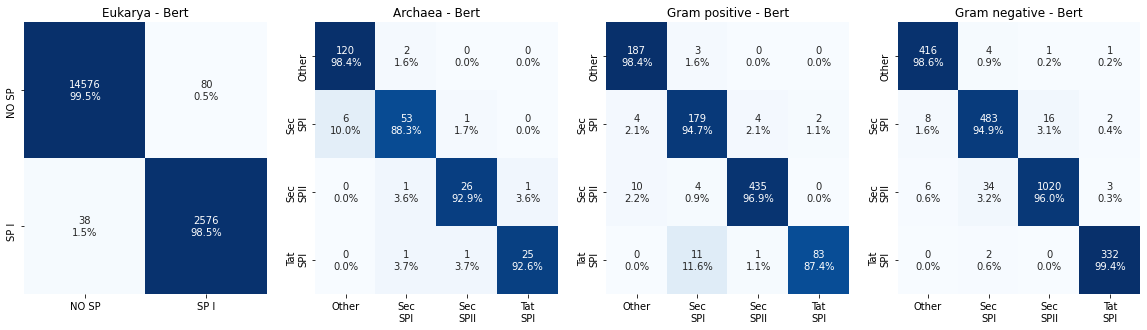

In [12]:
df_base = average_partition_validation_probs_and_predict(df)
get_mccs(df_base)
make_conf_matrices(df_base)

EUKARYA: 0.973
ARCHAEA: 0.921
POSITIVE: 0.937
NEGATIVE: 0.953
Average 0.946


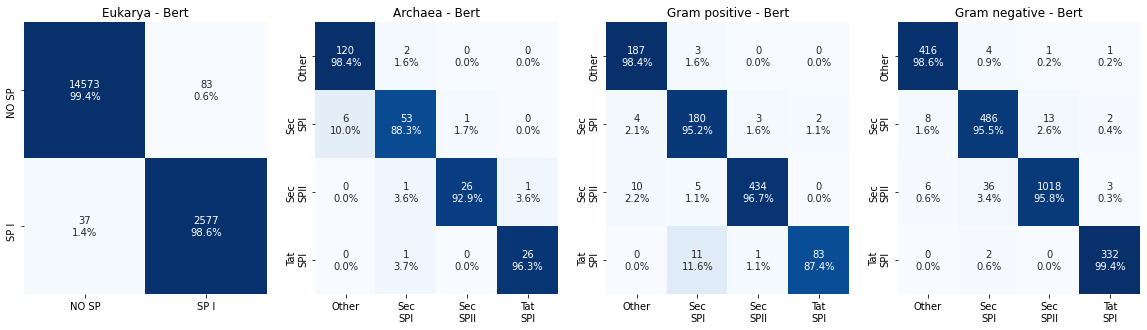

In [138]:
#π=(1/θ1, 1/θ2,..., 1/θN), for θi∈(0,1) and Σθi = 1,
weights = [0.245, 0.255, 0.245, 0.255]
assert sum(weights) == 1, 'Choose valid weights'

#TODO no renormalization is performed here. argmax doesn't care about that, but nice probability outputs would.
df_weighted = df.copy()
for i, cat in enumerate(['NO', 'SPI ', 'SPII', 'TAT']):
    weight = weights[i]
    cols = [x for x in df_weighted.columns if cat in x]
    df_weighted[cols] = df_weighted[cols] * weight
    
df_val = average_partition_validation_probs_and_predict(df_weighted)
get_mccs(df_val)
make_conf_matrices(df_val)

In [132]:
tested_weights = []
mccs = []

for x in range(200):
    weights = np.random.dirichlet([480,490,480,500])
    #assert sum(weights) == 1, 'Choose valid weights'

    #TODO no renormalization is performed here. argmax doesn't care about that, but nice probability outputs would.
    df_weighted = df.copy()
    for i, cat in enumerate(['NO', 'SPI ', 'SPII', 'TAT']):
        weight = weights[i]
        cols = [x for x in df_weighted.columns if cat in x]
        df_weighted[cols] = df_weighted[cols] * weight

    df_val = average_partition_validation_probs_and_predict(df_weighted)
    avg_mcc = get_mccs(df_val, print_all=False)
    mccs.append(avg_mcc)
    tested_weights.append(weights)
    
idx = np.array(mccs).argmax()
print(mccs[idx], tested_weights[idx])

0.9475344570876748 [0.27203294 0.22921113 0.24081773 0.25793821]


In [121]:
#0.9465634678980269  [0.25156357 0.23786097 0.23888103 0.27169443]
#0.94664481564489    [0.2263633  0.24457708 0.24385257 0.28520705]
#0.9469295326645014  [0.26921539 0.24122341 0.2388535  0.2507077 ]

np.random.dirichlet([500,490,480,500])
#0.9470081602166502 [0.25350596 0.24718109 0.23407969 0.26523326]
#0.946701557722347 [0.24309911 0.25658214 0.23581248 0.26450627]
#0.9468039654792026 [0.2546575  0.25464863 0.22851315 0.26218072]
np.random.dirichlet([480,490,480,500]
#0.9470081602166502 [0.2520763  0.24570801 0.23340741 0.26880828]
#0.9469028483687437 [0.25501709 0.24792847 0.2387841  0.25827033]
#0.9472193238422901 [0.24316418 0.2414561  0.24028127 0.27509846]
#0.9475344570876748 [0.27203294 0.22921113 0.24081773 0.25793821]
                    
                    
0.9482255980808402 [0.25442711 0.2025103  0.20211553 0.34094705]
[508.49071436 340.24135964 364.71398047 872.58401996]

array([0.24054139, 0.23574774, 0.23029958, 0.29341129])

## Dirichlet descent

```
#start with uniform dirichlet sample for given expected variance
support = [500] * n
max_score = 0
best_weights = []

#test current parameters
for n in random_starts:
    weights = dirichlet(support).sample()
    score = predict_and_compute(preds, weights)
    if score > max_score:
        max_score = score
        best_weights = weights
        
#update parameters
#support = support * best_weights/best_weights.mean() 

```

```
# Initialize parameters
distribution_parameters = [init_variance_parameter] * num_classes 
best_score=0
best_weights= []

for iteration in iterations do:
    for i in n_random_samples do:
        weights = np.random.dirichlet(distribution_parameters)
        weighted_probs = probs*weights
        metric = compute_metric(weighted_probs)
        if metric>best_score:
            best_weights = weights
            
        distribution_parameters = distribution_parameters * best_weights * increase_rate
        
```

In [ ]:
def optimize_thresholds(probs: np.ndarray, compute_metric: Callable, num_classes: int, 
                       init_variance_parameter: float = 5.0,
                       increase_rate: float = 300.0,
                       iterations: int = 4)

    #initialize uniform dirichlet distribution
    distribution_parameters = [init_variance_parameter] * num_classes 
    best_score=0
    best_weights= []

    for iteration in iterations do:
        for i in n_random_samples do:
            weights = np.random.dirichlet(distribution_parameters)
            weighted_probs = probs*weights
            metric = compute_metric(weighted_probs)
            if metric>best_score:
                best_weights = weights
            
            #update distribution
            distribution_parameters = distribution_parameters * best_weights * increase_rate
            
    return best_weights

In [136]:
from tqdm.notebook import tqdm

## low dirichlet numbers pull towards a value? need to invert setup.

0.9503216903336349 [0.12546256 0.2286544  0.2274393  0.41844374]
[ 42.63876823  73.59631932  73.2317913  130.53312115]
0.9512169560998687 [0.12082056 0.25808946 0.23074004 0.39034994]
[ 78.88493676 151.02315603 142.45380344 247.63810378]
0.951376461365269 [0.12499758 0.27147923 0.22879993 0.37472326]
[116.38421216 232.46692394 211.09378199 360.05508192]
0.951376461365269 [0.12499758 0.27147923 0.22879993 0.37472326]
[153.88348756 313.91069186 279.73376053 472.47206006]



Text(0.5, 1.0, 'Dirichlet descent threshold finding')

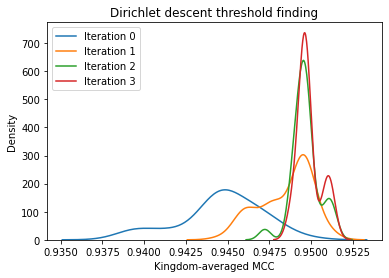

In [180]:
variance_parameter = 5
increase_rate = 300
iterations = 4

support = [variance_parameter] *4

best_score = 0
best_weights = []
scores_list = []
for iteration in tqdm(range(iterations)):
    

    scores = []
    for x in range(100- iteration*20):
        weights = np.random.dirichlet(support)
        #assert sum(weights) == 1, 'Choose valid weights'

        #TODO no renormalization is performed here. argmax doesn't care about that, but nice probability outputs would.
        df_weighted = df.copy()
        for i, cat in enumerate(['NO', 'SPI ', 'SPII', 'TAT']):
            weight = weights[i]
            cols = [x for x in df_weighted.columns if cat in x]
            df_weighted[cols] = df_weighted[cols] * weight
            
        
        df_val = average_partition_validation_probs_and_predict(df_weighted)
        avg_mcc = get_mccs(df_val, print_all=False)
        scores.append(avg_mcc)
        if avg_mcc>best_score:
            best_score = avg_mcc
            best_weights = weights

    sns.kdeplot(scores)
    scores_list.append(best_score)
    support = support + best_weights*increase_rate#best_weights* variance_parameter * len(support) #support * (best_weights/best_weights.mean())
    print(best_score, best_weights)
    print(support)
    
plt.legend(['Iteration ' + str(x) for x in list(range(iterations))])
plt.xlabel('Kingdom-averaged MCC')
plt.title('Dirichlet descent threshold finding')

EUKARYA: 0.970
ARCHAEA: 0.941
POSITIVE: 0.944
NEGATIVE: 0.951
Average 0.951


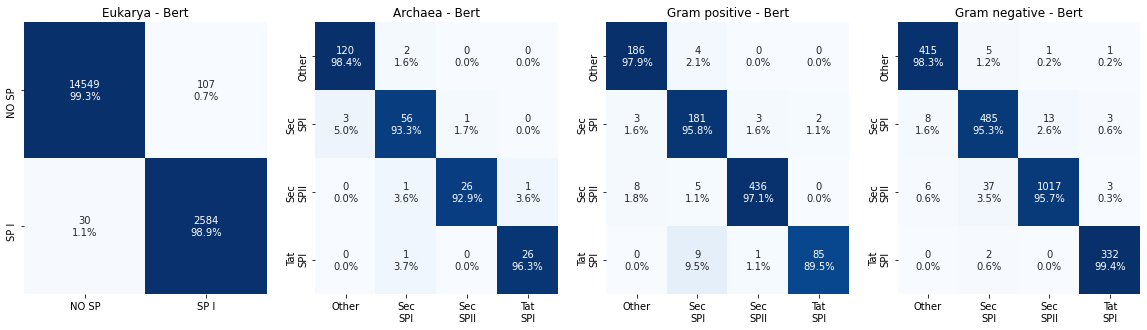

In [224]:
weights = [0.32565215, 0.21573308, 0.21418409, 0.24443067]
weights = [0.25324277, 0.24677669, 0.24467345, 0.25530708] # Good!
weights = [0.27665077, 0.22989188, 0.2280553,  0.26540205]
weights = [0.13308215, 0.28698059, 0.2846527,  0.29528455] #very good - somehow doesn't overfit, although seems so.
weights = [0.13983982, 0.29855944, 0.25394953, 0.30765122]

#TODO no renormalization is performed here. argmax doesn't care about that, but nice probability outputs would.
df_weighted = df.copy()
for i, cat in enumerate(['NO', 'SPI ', 'SPII', 'TAT']):
    weight = weights[i]
    cols = [x for x in df_weighted.columns if cat in x]
    df_weighted[cols] = df_weighted[cols] * weight
    
df_val = average_partition_validation_probs_and_predict(df_weighted)
get_mccs(df_val)
make_conf_matrices(df_val)

EUKARYA: 0.969
ARCHAEA: 0.941
POSITIVE: 0.929
NEGATIVE: 0.943
Average 0.946


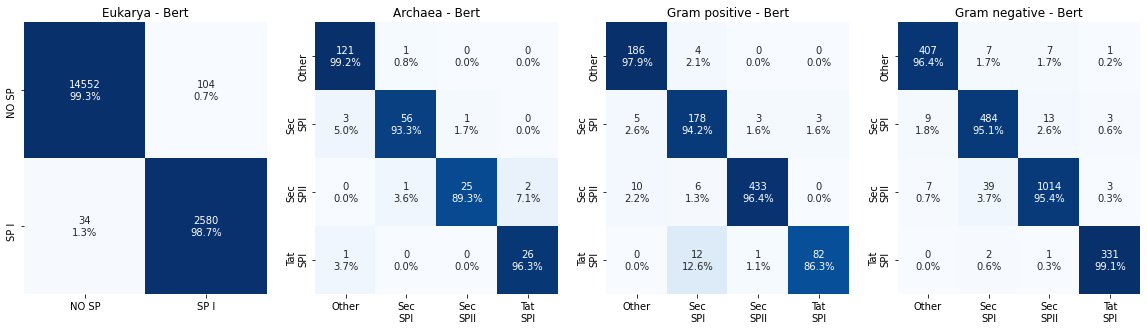

In [225]:
df_test = average_partition_test_probs_and_predict(df_weighted)
get_mccs(df_test)
make_conf_matrices(df_test)

### Get full metrics

In [16]:
sys.path.append('../../')
from train_scripts.downstream_tasks.metrics_utils import compute_metrics

In [170]:
def crossvalidatation_metrics_from_df(df, weights_list = None):
    results_list = []
    for test_partition in [0,1,2,3,4]:
        for val_partition in [0,1,2,3,4]:
            if test_partition != val_partition:
                test_set_sequences = df.loc[df['Partition']==test_partition]#.filter(regex=f'T{test_partition}V{val_partition}', axis=1)

                all_kingdom_ids = test_set_sequences['Kingdom']
                all_global_targets = test_set_sequences['target']
                all_cs_targets = test_set_sequences['CS target']
                all_cs_preds = test_set_sequences[f'CS model T{test_partition}V{val_partition}']
                test_set_sequences.filter(regex=f'T{test_partition}V{val_partition}', axis=1)
                probs = test_set_sequences[[f'p_NO model T{test_partition}V{val_partition}', 
                                            f'p_SPI model T{test_partition}V{val_partition}', 
                                            f'p_SPII model T{test_partition}V{val_partition}', 
                                            f'p_TAT model T{test_partition}V{val_partition}']]
                if weights_list:
                    probs = probs.values * weights_list[test_partition]
                else: 
                    probs = probs.values
                all_global_preds = probs.argmax(axis=1)

                #compute_metrics
                metrics = compute_metrics(all_global_targets, all_global_preds, all_cs_targets, all_cs_preds, all_kingdom_ids)
                results_list.append(metrics)

                crossval_df = pd.DataFrame.from_dict(results_list).T
            
    return crossval_df

In [84]:
crossval_df = crossvalidatation_metrics_from_df(df)
metrics = crossval_df.drop(crossval_df.filter(regex='NO_SP', axis=0).index).mean(axis=1)

In [113]:
weights = [0.32565215, 0.21573308, 0.21418409, 0.24443067]

#TODO no renormalization is performed here. argmax doesn't care about that, but nice probability outputs would.
df_weighted = df.copy()
for i, cat in enumerate(['NO', 'SPI ', 'SPII', 'TAT']):
    weight = weights[i]
    cols = [x for x in df_weighted.columns if cat in x]
    df_weighted[cols] = df_weighted[cols] * weight
    
crossval_df = crossvalidatation_metrics_from_df(df_weighted)
metrics_weighted = crossval_df.drop(crossval_df.filter(regex='NO_SP', axis=0).index).mean(axis=1)

/mnt/c/Users/felix/Coding/protein_modeling/testenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
../../train_scripts/downstream_tasks/metrics_utils.py:196: RuntimeWarning: invalid value encountered in long_scalars
  recall = correct_in_window.sum()/(true_CS != -1).sum()
../../train_scripts/downstream_tasks/metrics_utils.py:195: RuntimeWarning: invalid value encountered in long_scalars
  precision = correct_in_window.sum()/(pred_CS != -1).sum()


In [114]:
compare = metrics_weighted / metrics
compare = compare.loc[compare !=1.0]
print(compare.to_string(float_format = '%.3f'))


mcc                  1.000
EUKARYA_SP_mcc2      1.001
EUKARYA_SP_mcc1      1.001
NEGATIVE_SP_mcc2     1.000
NEGATIVE_SP_mcc1     1.001
NEGATIVE_LIPO_mcc2   1.000
NEGATIVE_LIPO_mcc1   1.001
NEGATIVE_TAT_mcc1    1.001
POSITIVE_SP_mcc2     1.001
POSITIVE_SP_mcc1     1.000
POSITIVE_LIPO_mcc1   1.001
POSITIVE_TAT_mcc1    1.002


Overall weight assignment, aimed at optimizing confusion matrix, does not seem to work for cross-validation metrics.

### Different weights for each inner fold

In [134]:
#define function to get average of a fold
def inner_fold_average_kingdom_mcc_from_df(df, fold=0, weights_list = None):
    averages = []
    for val_partition in [0,1,2,3,4]:
        if val_partition !=fold:
            
            #get relevant sequences
            test_set_sequences = df.loc[df['Partition']==val_partition]

            all_kingdom_ids = test_set_sequences['Kingdom']
            all_global_targets = test_set_sequences['target']

            probs = test_set_sequences[[f'p_NO model T{fold}V{val_partition}', 
                                        f'p_SPI model T{fold}V{val_partition}', 
                                        f'p_SPII model T{fold}V{val_partition}', 
                                        f'p_TAT model T{fold}V{val_partition}']]
            if weights_list:
                probs = probs.values * weights[test_partition]
            else: 
                probs = probs.values
            all_global_preds = probs.argmax(axis=1)

            #compute_metrics
            mccs = []
            for kingdom in all_kingdom_ids.unique():
                #subset preds and targets
                k_preds = all_global_preds[all_kingdom_ids == kingdom]
                k_targets = all_global_targets.loc[all_kingdom_ids ==kingdom]
                mccs.append(matthews_corrcoef(k_preds, k_targets))
            
            averages.append(sum(mccs)/len(mccs))
                
    return sum(averages)/len(averages)

In [156]:
#use this average in fold function in diriclet loop
def dirichlet_optimize_weights(df, fold =0, variance_parameter=5, increase_rate=300, iterations =4):

    support = [variance_parameter] *4
    best_score = 0
    best_weights = []
    scores_list = []
    for iteration in tqdm(range(iterations)):


        scores = []
        for x in range(100- iteration*20):
            weights = np.random.dirichlet(support)
            #assert sum(weights) == 1, 'Choose valid weights'

            #TODO no renormalization is performed here. argmax doesn't care about that, but nice probability outputs would.
            df_weighted = df.copy()
            for i, cat in enumerate(['NO', 'SPI ', 'SPII', 'TAT']):
                weight = weights[i]
                cols = [x for x in df_weighted.columns if cat in x]
                df_weighted[cols] = df_weighted[cols] * weight


            avg_mcc = inner_fold_average_kingdom_mcc_from_df(df_weighted, fold)
            scores.append(avg_mcc)
            if avg_mcc>best_score:
                best_score = avg_mcc
                best_weights = weights

        sns.kdeplot(scores)
        scores_list.append(best_score)
        support = support + best_weights*increase_rate#best_weights* variance_parameter * len(support) #support * (best_weights/best_weights.mean())
        print(best_score, best_weights)
        print(support)
        
    default_mcc = inner_fold_average_kingdom_mcc_from_df(df, fold)
    plt.axvline(default_mcc, c='black')

    plt.legend(['Iteration ' + str(x) for x in list(range(iterations))])
    plt.xlabel('Kingdom-averaged MCC')
    plt.title('Dirichlet descent threshold finding')
    
    return best_weights

0.9469128143192433 [0.19318281 0.35242399 0.16419573 0.29019746]
[ 62.95484401 110.72719827  54.25871989  92.05923782]
0.9469808855462927 [0.21556589 0.37646713 0.14973534 0.25823163]
[127.62461166 223.66733734  99.17932304 169.52872797]
0.9469808855462927 [0.21556589 0.37646713 0.14973534 0.25823163]
[192.2943793  336.6074764  144.09992619 246.99821811]
0.9469808855462927 [0.21556589 0.37646713 0.14973534 0.25823163]
[256.96414695 449.54761546 189.02052934 324.46770825]



/mnt/c/Users/felix/Coding/protein_modeling/testenv/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


0.9454992358899119 [0.39337767 0.1754193  0.17275803 0.258445  ]
[123.01329974  57.62578916  56.82741029  82.5335008 ]
0.9454992358899119 [0.39337767 0.1754193  0.17275803 0.258445  ]
[241.02659949 110.25157833 108.65482059 160.0670016 ]


/mnt/c/Users/felix/Coding/protein_modeling/testenv/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


0.9454992358899119 [0.39337767 0.1754193  0.17275803 0.258445  ]
[359.03989923 162.87736749 160.48223088 237.6005024 ]
0.9454992358899119 [0.39337767 0.1754193  0.17275803 0.258445  ]
[477.05319897 215.50315665 212.30964118 315.1340032 ]



/mnt/c/Users/felix/Coding/protein_modeling/testenv/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


0.9395296815767884 [0.27355706 0.25630547 0.11346962 0.35666785]
[ 87.06711797  81.89164033  39.0408853  112.0003564 ]
0.9397210436735792 [0.28688709 0.24922994 0.1080622  0.35582077]
[173.13324485 156.66062295  71.45954594 218.74658626]
0.939904737966638 [0.2720082  0.22904124 0.12211823 0.37683234]
[254.73570421 225.37299496 108.09501368 331.79628715]
0.939904737966638 [0.2720082  0.22904124 0.12211823 0.37683234]
[336.33816357 294.08536696 144.73048143 444.84598804]



0.9398817548976641 [0.24437633 0.38031815 0.19416418 0.18114134]
[ 78.31289776 119.09544506  63.24925479  59.3424024 ]
0.9403383130602554 [0.25369911 0.37328088 0.18732615 0.18569385]
[154.42263201 231.07971047 119.4470999  115.05055762]
0.9403383130602554 [0.25369911 0.37328088 0.18732615 0.18569385]
[230.53236627 343.06397589 175.644945   170.75871284]
0.9403383130602554 [0.25369911 0.37328088 0.18732615 0.18569385]
[306.64210052 455.04824131 231.84279011 226.46686806]



0.9466909554087387 [0.21084376 0.40253085 0.16275004 0.22387534]
[ 68.25312937 125.75925573  53.82501203  72.16260287]
0.9467534852377714 [0.24511974 0.40948357 0.14650845 0.19888824]
[141.78905065 248.60432713  97.777546   131.82907622]
0.9467534852377714 [0.24511974 0.40948357 0.14650845 0.19888824]
[215.32497194 371.44939853 141.73007997 191.49554957]
0.9467534852377714 [0.24511974 0.40948357 0.14650845 0.19888824]
[288.86089322 494.29446992 185.68261394 251.16202291]



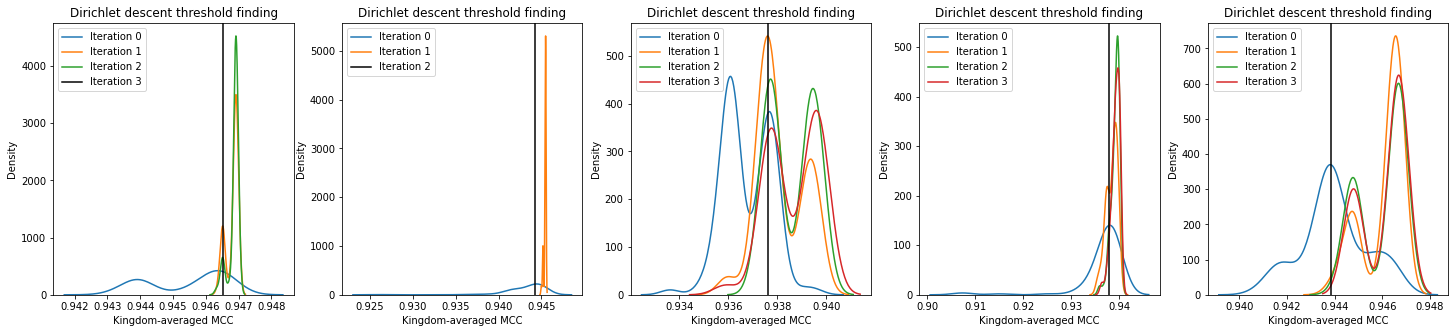

In [177]:
weightlist = []

plt.figure(figsize=(25,5))

plt.subplot(1,5,1)
weights= dirichlet_optimize_weights(df, fold=0)
weightlist.append(weights)
plt.subplot(1,5,2)
weights= dirichlet_optimize_weights(df, fold=1)
weightlist.append(weights)
plt.subplot(1,5,3)
weights= dirichlet_optimize_weights(df, fold=2)
weightlist.append(weights)
plt.subplot(1,5,4)
weights= dirichlet_optimize_weights(df, fold=3)
weightlist.append(weights)
plt.subplot(1,5,5)
weights= dirichlet_optimize_weights(df, fold=4)
weightlist.append(weights)

In [179]:
crossval_df = crossvalidatation_metrics_from_df(df, weights_list=weightlist)
metrics_weighted = crossval_df.drop(crossval_df.filter(regex='NO_SP', axis=0).index).mean(axis=1)
compare = metrics_weighted / metrics
compare = compare.loc[compare !=1.0]
print(compare.to_string(float_format = '%.3f'))

mcc                  1.000
EUKARYA_SP_mcc2      1.000
EUKARYA_SP_mcc1      1.000
NEGATIVE_SP_mcc2     1.000
NEGATIVE_SP_mcc1     1.003
NEGATIVE_LIPO_mcc2   1.001
NEGATIVE_LIPO_mcc1   1.001
NEGATIVE_TAT_mcc1    1.002
POSITIVE_SP_mcc2     1.001
POSITIVE_LIPO_mcc1   1.000


In [291]:
np.exp(1.480056028698038)

4.39319181884114